In [29]:
from typing import List, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import quantstats_lumi as qs
import requests
import math
import utils

from tqdm import tqdm

sns.set_palette(sns.color_palette("hls", 12))

plt.style.use("ggplot")
STARTING_PERIOD = "2014-01-01"

In [34]:
data = pd.read_excel("FTSEMIB_tickers.xlsx")
previousClose = []
marketCap = []
shares = []

for stock in tqdm(data["ticker"]):
    ticker = yf.Ticker(stock)
    previousClose.append(ticker.fast_info["previousClose"])
    marketCap.append(ticker.fast_info["marketCap"])
    shares.append(ticker.fast_info["shares"])
        
data["previousClose"] = previousClose
data["marketCap"] = marketCap
data["shares"] = shares
data.sort_values(by=["sector", "marketCap"], ascending=[True, False], inplace=True, ignore_index=True)

returns_data = yf.download(tickers=list(data["ticker"]), actions=True).loc[STARTING_PERIOD:]
returns_data.drop(columns=["Open", "High", "Low", "Volume"], inplace=True)

avg_return = []
yearly_return = []
volatility = []
max_drawdown = []

for ticker in tqdm(data["ticker"]):
    ret_series = utils.compute_returns(returns_data[("Adj Close", ticker)]).dropna()
    
    avg_return.append(ret_series.mean())
    volatility.append(qs.stats.volatility(ret_series))
    max_drawdown.append(qs.stats.max_drawdown(ret_series))
    yearly_return.append(utils.compute_yearly_compounded_returns(ret_series, prices=False))
    
data["avg_return"] = avg_return
data["yearly_return"] = yearly_return
data["volatility"] = volatility
data["max_drawdown"] = max_drawdown

100%|██████████| 40/40 [00:09<00:00,  4.38it/s]
[*********************100%%**********************]  39 of 39 completed
100%|██████████| 40/40 [00:00<00:00, 40.51it/s]


In [39]:
portfolio = data[data["marketCap"] > 10_000_000_000]

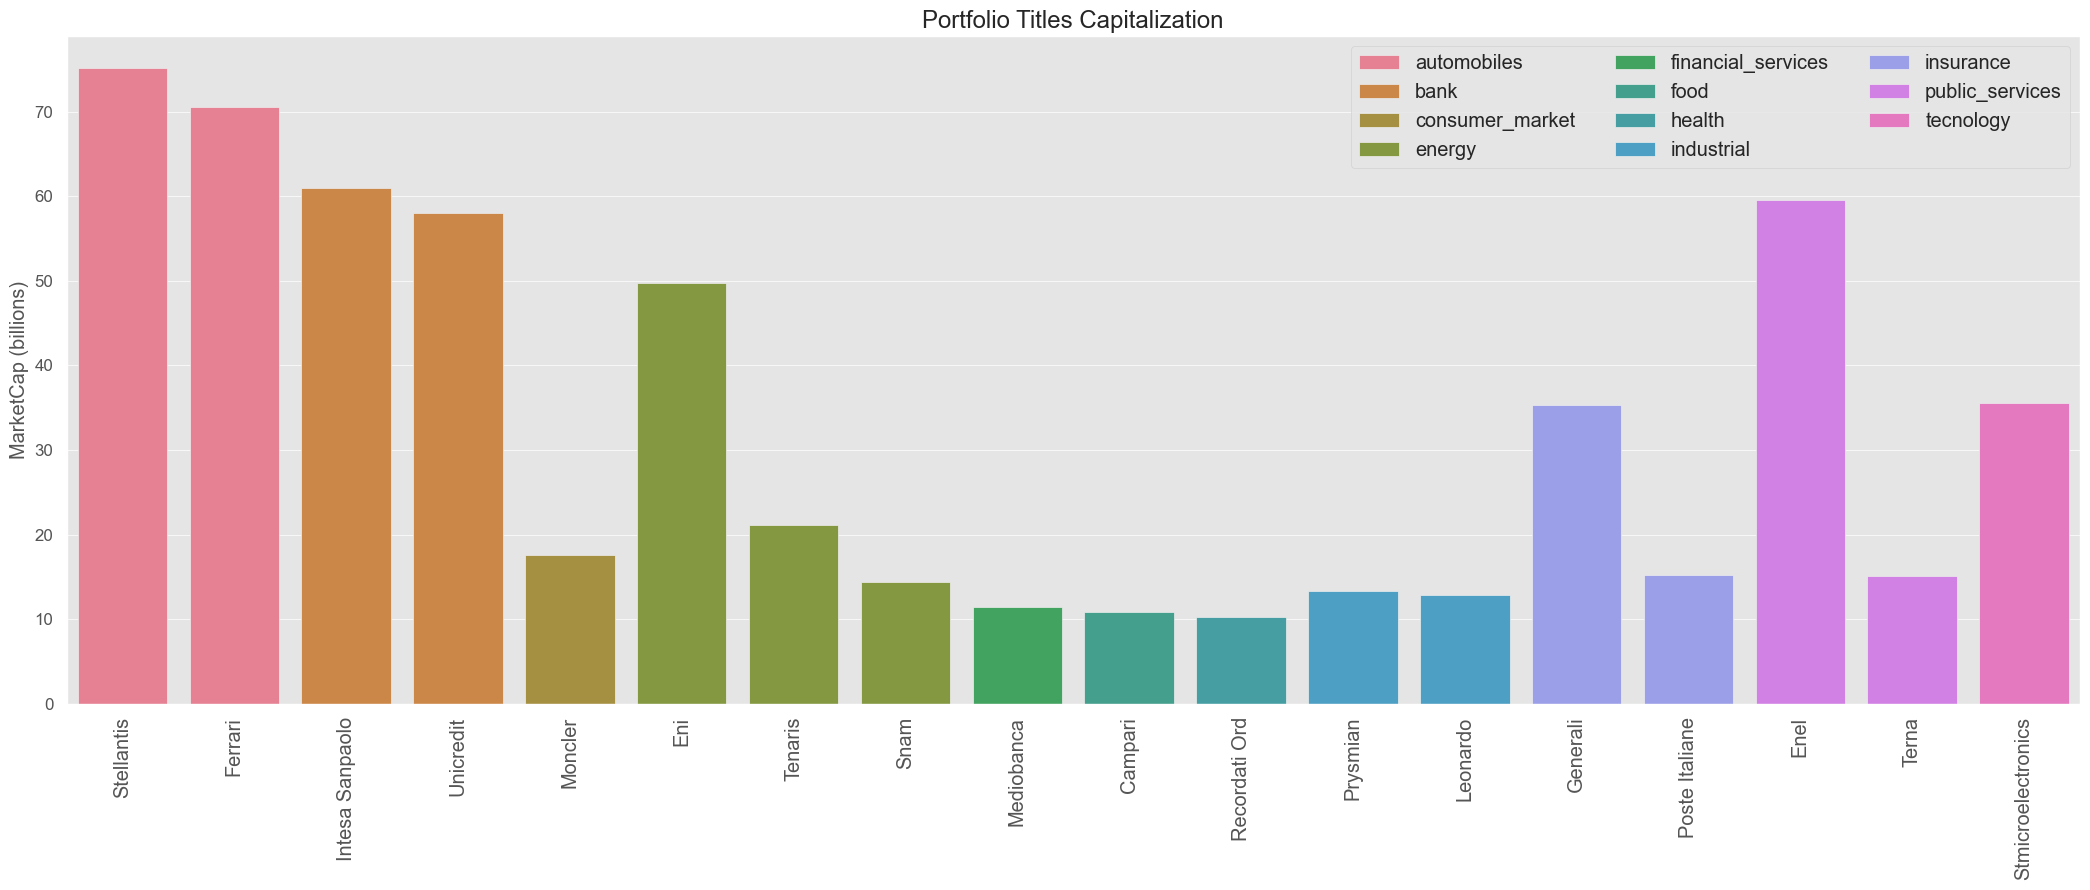

In [40]:
fig, ax = plt.subplots(tight_layout=True, figsize=(21, 9))

sns.barplot(data=portfolio, x="name", y=data["marketCap"]/1_000_000_000, hue="sector", ax=ax)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='center', fontsize="x-large")
ax.set_title("Portfolio Titles Capitalization", fontsize="xx-large")
ax.set_xlabel("", fontsize="x-large")
ax.set_ylabel("MarketCap (billions)", fontsize="x-large")
ax.legend(ncols=3, fontsize="x-large")
plt.show()

In [52]:
portfolio_components_returns = utils.compute_returns(returns_data["Adj Close"][list(portfolio["ticker"])])

<Axes: xlabel='Ticker', ylabel='Ticker'>

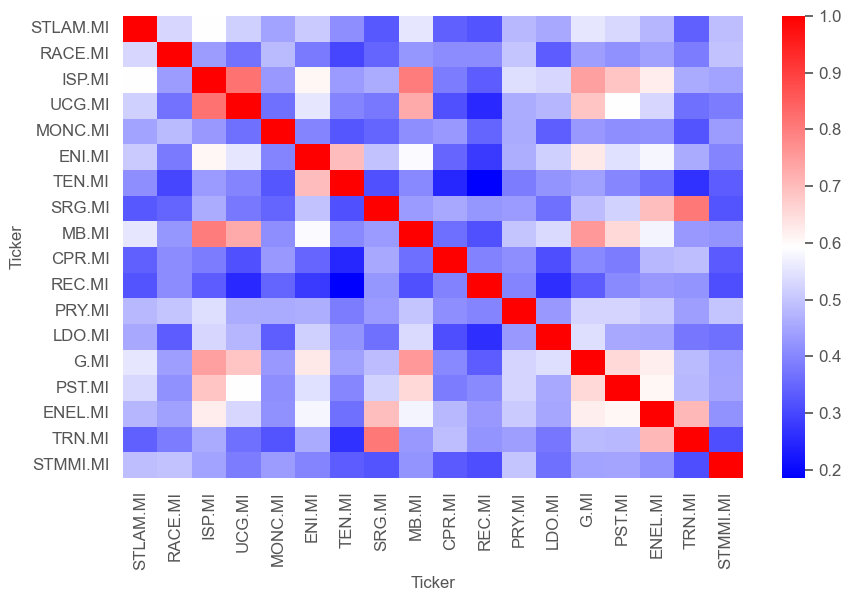

In [57]:
sns.heatmap(portfolio_components_returns.corr(), cmap="bwr")